# Location Based Assignment
### The Cost of Basic Goods

#### CS146


- What is the basic average price for each product? (convert currencies)

- How much do the following factors modify the basic price?
  - Geographical location
  - Grocery store brand (budget, mid-range, luxury)

  Explain how strong each of these effects are. Which has the greatest influence on price variation between shops?

- Does price variation by geographical location correlate with variation in rental prices or not?

In [ ]:
# load relevant libraries
import csv
import pystan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as sts

# Initial Data Preprocessing

Before importing the data I: 
- Removed bits of text and currency signs from the rental data
- Standardized the countries
- Rename the columns to each product (e.g. Apple 1, Apple 2, Apple 3)

In [ ]:
data_url = "https://gist.githubusercontent.com/ibrisa/97fcd762bcddb7349915856a31622e24/raw/d3b961b4a530ee1a8d5bd9751754109dffb2a2e7/lbadata.csv"

data = pd.read_csv(data_url)

data.head()

,Timestamp,Email Address,Your name,Country where you (and the grocery store) are,"Currency (e.g. EUR, GBP, USD)",Grocery store name and street address (or URL if shopping online),Price perception of the store brand,Average rental price near the grocery store,Apple 1 quantity (kg),Apple 1 price,Apple 2 quantity (kg),Apple 2 price,Apple 3 quantity (kg),Apple 3 price,Banana 1 quantity (kg),Banana 1 price,Banana 2 quantity (kg),Banana 2 price,Banana 3 quantity (kg),Banana 3 price,Tomatoes 1 quantity (kg),Tomatoes 1 price,Tomatoes 2 quantity (kg),Tomatoes 2 price,Tomatoes 3 quantity (kg),Tomatoes 3 price,Potatoes 1 quantity (kg),Potatoes 1 price,Potatoes 2 quantity (kg),Potatoes 2 price,Potatoes 3 quantity (kg),Potatoes 3 price,Flour 1 quantity (kg),Flour 1 price,Flour 2 quantity (kg),Flour 2 price,Flour 3 quantity (kg),Flour 3 price,Rice 1 quantity (kg),Rice 1 price,Rice 2 quantity (kg),Rice 2 price,Rice 3 quantity (kg),Rice 3 price,Milk 1 quantity (liters),Milk 1 price,Milk 2 quantity (liters),Milk 2 price,Milk 3 quantity (liters),Milk 3 price,Butter 1 quantity (kg),Butter 1 price,Butter 2 quantity (kg),Butter 2 price,Butter 3 quantity (kg),Butter 3 price,Eggs 1 quantity (count),Eggs 1 price,Eggs 2 quantity (count),Eggs 2 price,Eggs 3 quantity (count),Eggs 3 price,Chicken 1 quantity (kg),Chicken 1 price,Chicken 2 quantity (kg),Chicken 2 price,Chicken 3 quantity (kg),Chicken 3 price
0,3/4/2021 4:03:50,isabel@minerva.kgi.edu,Isabel Brunkan,Canada,CAD,Thrifty's (https://www.thriftyfoods.com),Budget (cheap),1450,1.360,4.75,1.360,4.99,1.360,4.75,0.190,0.33,0.180,0.47,0.080,0.35,0.230,1.77,0.454,5.99,0.180,2.77,0.100,0.44,0.100,0.44,1.000,3.08,2.500,7.49,2.500,3.99,10.000,13.99,1.600,12.99,0.24,4.49,0.907,5.29,2.00,6.49,4.000,6.49,1.50,5.29,0.454,4.49,0.454,6.49,0.454,7.49,18.0,9.05,18.0,8.19,12.0,5.75,0.400,9.25,0.600,16.25,0.780,16.32
1,2/28/2021 20:28:38,isabel@minerva.kgi.edu,Isabel Brunkan,Canada,CAD,Save On Foods - Foul Bay (https://www.saveonfo...,Budget (cheap),1550,0.100,0.66,0.100,0.44,0.100,0.88,0.100,0.17,0.100,0.20,0.100,0.66,0.100,0.66,0.100,0.77,0.100,0.66,0.100,0.31,0.100,0.44,0.100,0.18,10.000,12.99,2.000,9.99,1.000,4.99,0.100,0.29,4.54,19.99,2.000,9.99,1.00,4.19,1.000,2.60,4.00,5.29,0.454,4.39,0.454,5.69,0.454,7.69,12.0,5.45,12.0,7.49,12.0,7.69,3.000,23.08,0.100,1.21,0.500,12.11
2,3/2/2021 2:34:17,claudiagold@minerva.kgi.edu,Claudia Jin,USA,USD,"Target; 225 Bush St Ste 100, San Francisco, CA...",Mid-range,2996,1.361,4.69,1.361,3.59,1.361,2.99,0.910,1.79,0.120,0.25,NaN,NaN,0.454,3.19,0.454,1.29,0.300,2.99,2.268,2.59,0.680,4.99,0.680,3.99,2.268,3.69,0.910,1.89,0.910,10.99,0.240,1.39,0.85,5.99,0.910,3.29,1.89,2.19,1.890,1.99,1.67,3.99,0.430,2.29,0.450,3.69,0.370,5.29,12.0,1.69,18.0,2.39,12.0,3.99,0.454,5.99,1.134,8.59,1.814,8.49
3,3/2/2021 2:32:10,claudiagold@minerva.kgi.edu,Claudia Jin,USA,USD,"Wholefoods; 399 4th St San Francisco, CA 94107",Luxury (expensive),3360,0.454,2.49,0.454,2.99,0.454,3.99,0.454,0.49,0.454,1.49,0.454,1.99,0.454,1.99,0.454,1.79,0.454,2.99,0.454,0.99,0.454,1.29,0.454,1.49,2.268,7.99,2.268,9.79,2.268,7.29,1.814,8.99,0.91,3.95,0.850,6.99,3.79,5.79,0.236,0.59,0.95,4.99,0.450,4.49,0.450,8.39,0.250,4.99,12.0,8.69,12.0,5.99,12.0,5.79,0.454,4.99,0.454,5.99,0.454,6.99
4,3/9/2021 23:24:18,koredeakande@minerva.kgi.edu,Korede Akande,USA,USD,Foodsco (foodsco.net),Budget (cheap),4000,0.454,1.99,0.454,1.19,0.454,0.99,0.454,0.59,0.454,0.69,0.454,0.79,0.454,1.29,0.454,1.79,0.454,1.69,4.500,2.99,0.454,0.79,0.454,0.99,0.907,1.99,2.270,2.69,2.270,2.19,0.907,4.49,2.27,7.99,0.280,2.49,3.79,3.47,1.390,2.99,3.79,1.99,0.454,3.69,0.454,4.49,0.454,4.99,12.0,3.99,12.0,4.49,12.0,2.99,0.454,5.99,1.133,5.49,0.454,4.49


### Filter for Relevant Columns
These would be price of something or the product/quantity

In [ ]:
# Drop irrelevant columns
data.drop(['Timestamp','Email Address','Your name','Grocery store name and street address (or URL if shopping online)'], axis = 1, inplace = True)

In [ ]:
cols = data.columns.to_list()

price = [col for col in cols if 'price' in col]
quantity = [col for col in cols if 'quantity' in col]

#includes the rental price so drop that
price = price[1:] 

# confirm they are the same length
print('Length of Price List:', len(price))
print('Length of Quantity List:', len(quantity))

# preview the lists
print(price)
print(quantity)

Length of Price List: 30
Length of Quantity List: 30
['Apple 1 price', 'Apple 2 price', 'Apple 3 price', 'Banana 1 price', 'Banana 2 price', 'Banana 3 price', 'Tomatoes 1 price', 'Tomatoes 2 price', 'Tomatoes 3 price', 'Potatoes 1 price', 'Potatoes 2 price', 'Potatoes 3 price', 'Flour 1 price', 'Flour 2 price', 'Flour 3 price', 'Rice 1 price', 'Rice 2 price', 'Rice 3 price', 'Milk 1 price', 'Milk 2 price', 'Milk 3 price', 'Butter 1 price', 'Butter 2 price', 'Butter 3 price', 'Eggs 1 price', 'Eggs 2 price', 'Eggs 3 price', 'Chicken 1 price', 'Chicken 2 price', 'Chicken 3 price']
['Apple 1 quantity (kg)', 'Apple 2 quantity (kg)', 'Apple 3 quantity (kg)', 'Banana 1 quantity (kg)', 'Banana 2 quantity (kg)', 'Banana 3 quantity (kg)', 'Tomatoes 1 quantity (kg)', 'Tomatoes 2 quantity (kg)', 'Tomatoes 3 quantity (kg)', 'Potatoes 1 quantity (kg)', 'Potatoes 2 quantity (kg)', 'Potatoes 3 quantity (kg)', 'Flour 1 quantity (kg)', 'Flour 2 quantity (kg)', 'Flour 3 quantity (kg)', 'Rice 1 quantity (

In [ ]:
# Extract the rental price to just numbers - I did this manually and just removed the string parts
# Confirm that they're all integers
data['Average rental price near the grocery store'].dtypes

dtype('int64')

In [ ]:
# Define all the currencies used in the data and normalize the prices
# prices as of March 10 5pm PST-ish
currency_dict = { 'CAD': 0.79,
                 'SEK' : 0.12,
                 'UAH' : 0.036,
                 'KES' : 0.0091,
                 'BRL' : 0.18,
                 'BDT' : 0.012,
                'USD' : 1}

# Replace each currency column value with whatever the exchange rate is
data['Currency (e.g. EUR, GBP, USD)'] = data['Currency (e.g. EUR, GBP, USD)'].replace(currency_dict).astype('float64')

# Convert the prices to each currency and normalize according to weight
for product in range(len(quantity)): 
  # convert to currency
  data[price[product]] = data[price[product]] * data['Currency (e.g. EUR, GBP, USD)']
  # normalize according to weight
  data[price[product]] = data[price[product]] / data[quantity[product]]


In [ ]:
# also need to normalize the rental prices
# create a new column for normalized rent
data['Rent'] = np.nan

# take the index and rent 
for idx, x in enumerate(data['Average rental price near the grocery store']):
  # normalize the rent
  new_rent = data['Currency (e.g. EUR, GBP, USD)'][idx]*x
  # save the new rent at the same index
  data['Rent'][idx]=new_rent

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
# Rename columns to shorter
data.rename(columns={'Country where you (and the grocery store) are': 'Country', 'Currency (e.g. EUR, GBP, USD)': 'Currency','Price perception of the store brand':'Brand'}, inplace= True)

# Preview the data
data.head()

,Country,Currency,Brand,Average rental price near the grocery store,Apple 1 quantity (kg),Apple 1 price,Apple 2 quantity (kg),Apple 2 price,Apple 3 quantity (kg),Apple 3 price,Banana 1 quantity (kg),Banana 1 price,Banana 2 quantity (kg),Banana 2 price,Banana 3 quantity (kg),Banana 3 price,Tomatoes 1 quantity (kg),Tomatoes 1 price,Tomatoes 2 quantity (kg),Tomatoes 2 price,Tomatoes 3 quantity (kg),Tomatoes 3 price,Potatoes 1 quantity (kg),Potatoes 1 price,Potatoes 2 quantity (kg),Potatoes 2 price,Potatoes 3 quantity (kg),Potatoes 3 price,Flour 1 quantity (kg),Flour 1 price,Flour 2 quantity (kg),Flour 2 price,Flour 3 quantity (kg),Flour 3 price,Rice 1 quantity (kg),Rice 1 price,Rice 2 quantity (kg),Rice 2 price,Rice 3 quantity (kg),Rice 3 price,Milk 1 quantity (liters),Milk 1 price,Milk 2 quantity (liters),Milk 2 price,Milk 3 quantity (liters),Milk 3 price,Butter 1 quantity (kg),Butter 1 price,Butter 2 quantity (kg),Butter 2 price,Butter 3 quantity (kg),Butter 3 price,Eggs 1 quantity (count),Eggs 1 price,Eggs 2 quantity (count),Eggs 2 price,Eggs 3 quantity (count),Eggs 3 price,Chicken 1 quantity (kg),Chicken 1 price,Chicken 2 quantity (kg),Chicken 2 price,Chicken 3 quantity (kg),Chicken 3 price,Rent
0,Canada,0.79,Budget (cheap),1450,1.360,2.759191,1.360,2.898603,1.360,2.759191,0.190,1.372105,0.180,2.062778,0.080,3.456250,0.230,6.079565,0.454,10.423128,0.180,12.157222,0.100,3.476000,0.100,3.476000,1.000,2.433200,2.500,2.366840,2.500,1.260840,10.000,1.105210,1.600,6.413812,0.24,14.779583,0.907,4.607607,2.00,2.563550,4.000,1.281775,1.50,2.786067,0.454,7.812996,0.454,11.293172,0.454,13.033260,18.0,0.397194,18.0,0.359450,12.0,0.378542,0.400,18.268750,0.600,21.395833,0.780,16.529231,1145.5
1,Canada,0.79,Budget (cheap),1550,0.100,5.214000,0.100,3.476000,0.100,6.952000,0.100,1.343000,0.100,1.580000,0.100,5.214000,0.100,5.214000,0.100,6.083000,0.100,5.214000,0.100,2.449000,0.100,3.476000,0.100,1.422000,10.000,1.026210,2.000,3.946050,1.000,3.942100,0.100,2.291000,4.54,3.478436,2.000,3.946050,1.00,3.310100,1.000,2.054000,4.00,1.044775,0.454,7.638987,0.454,9.901101,0.454,13.381278,12.0,0.358792,12.0,0.493092,12.0,0.506258,3.000,6.077733,0.100,9.559000,0.500,19.133800,1224.5
2,USA,1.00,Mid-range,2996,1.361,3.445996,1.361,2.637766,1.361,2.196914,0.910,1.967033,0.120,2.083333,NaN,NaN,0.454,7.026432,0.454,2.841410,0.300,9.966667,2.268,1.141975,0.680,7.338235,0.680,5.867647,2.268,1.626984,0.910,2.076923,0.910,12.076923,0.240,5.791667,0.85,7.047059,0.910,3.615385,1.89,1.158730,1.890,1.052910,1.67,2.389222,0.430,5.325581,0.450,8.200000,0.370,14.297297,12.0,0.140833,18.0,0.132778,12.0,0.332500,0.454,13.193833,1.134,7.574956,1.814,4.680265,2996.0
3,USA,1.00,Luxury (expensive),3360,0.454,5.484581,0.454,6.585903,0.454,8.788546,0.454,1.079295,0.454,3.281938,0.454,4.383260,0.454,4.383260,0.454,3.942731,0.454,6.585903,0.454,2.180617,0.454,2.841410,0.454,3.281938,2.268,3.522928,2.268,4.316578,2.268,3.214286,1.814,4.955899,0.91,4.340659,0.850,8.223529,3.79,1.527704,0.236,2.500000,0.95,5.252632,0.450,9.977778,0.450,18.644444,0.250,19.960000,12.0,0.724167,12.0,0.499167,12.0,0.482500,0.454,10.991189,0.454,13.193833,0.454,15.396476,3360.0
4,USA,1.00,Budget (cheap),4000,0.454,4.383260,0.454,2.621145,0.454,2.180617,0.454,1.299559,0.454,1.519824,0.454,1.740088,0.454,2.841410,0.454,3.942731,0.454,3.722467,4.500,0.664444,0.454,1.740088,0.454,2.180617,0.907,2.194046,2.270,1.185022,2.270,0.964758,0.907,4.950386,2.27,3.519824,0.280,8.892857,3.79,0.915567,1.390,2.151079,3.79,0.525066,0.454,8.127753,0.454,9.889868,0.454,10.991189,12.0,0.332500,12.0,0.374167,12.0,0.249167,0.454,13.193833,1.133,4.845543,0.454,9.889868,4000.0


In [ ]:
# Convert Country and Brand to Categorical Variables
# Country
data.Country = pd.Categorical(data.Country)
# plus 1 bc Stan uses 1-indexing
data['Country_Code'] = data.Country.cat.codes + 1

# Brand
data.Brand = pd.Categorical(data.Brand)
# plus 1 bc Stan uses 1-indexing
data['Brand_Code'] = data.Brand.cat.codes + 1
data.head()

,Country,Currency,Brand,Average rental price near the grocery store,Apple 1 quantity (kg),Apple 1 price,Apple 2 quantity (kg),Apple 2 price,Apple 3 quantity (kg),Apple 3 price,Banana 1 quantity (kg),Banana 1 price,Banana 2 quantity (kg),Banana 2 price,Banana 3 quantity (kg),Banana 3 price,Tomatoes 1 quantity (kg),Tomatoes 1 price,Tomatoes 2 quantity (kg),Tomatoes 2 price,Tomatoes 3 quantity (kg),Tomatoes 3 price,Potatoes 1 quantity (kg),Potatoes 1 price,Potatoes 2 quantity (kg),Potatoes 2 price,Potatoes 3 quantity (kg),Potatoes 3 price,Flour 1 quantity (kg),Flour 1 price,Flour 2 quantity (kg),Flour 2 price,Flour 3 quantity (kg),Flour 3 price,Rice 1 quantity (kg),Rice 1 price,Rice 2 quantity (kg),Rice 2 price,Rice 3 quantity (kg),Rice 3 price,Milk 1 quantity (liters),Milk 1 price,Milk 2 quantity (liters),Milk 2 price,Milk 3 quantity (liters),Milk 3 price,Butter 1 quantity (kg),Butter 1 price,Butter 2 quantity (kg),Butter 2 price,Butter 3 quantity (kg),Butter 3 price,Eggs 1 quantity (count),Eggs 1 price,Eggs 2 quantity (count),Eggs 2 price,Eggs 3 quantity (count),Eggs 3 price,Chicken 1 quantity (kg),Chicken 1 price,Chicken 2 quantity (kg),Chicken 2 price,Chicken 3 quantity (kg),Chicken 3 price,Rent,Country_Code,Brand_Code
0,Canada,0.79,Budget (cheap),1450,1.360,2.759191,1.360,2.898603,1.360,2.759191,0.190,1.372105,0.180,2.062778,0.080,3.456250,0.230,6.079565,0.454,10.423128,0.180,12.157222,0.100,3.476000,0.100,3.476000,1.000,2.433200,2.500,2.366840,2.500,1.260840,10.000,1.105210,1.600,6.413812,0.24,14.779583,0.907,4.607607,2.00,2.563550,4.000,1.281775,1.50,2.786067,0.454,7.812996,0.454,11.293172,0.454,13.033260,18.0,0.397194,18.0,0.359450,12.0,0.378542,0.400,18.268750,0.600,21.395833,0.780,16.529231,1145.5,3,1
1,Canada,0.79,Budget (cheap),1550,0.100,5.214000,0.100,3.476000,0.100,6.952000,0.100,1.343000,0.100,1.580000,0.100,5.214000,0.100,5.214000,0.100,6.083000,0.100,5.214000,0.100,2.449000,0.100,3.476000,0.100,1.422000,10.000,1.026210,2.000,3.946050,1.000,3.942100,0.100,2.291000,4.54,3.478436,2.000,3.946050,1.00,3.310100,1.000,2.054000,4.00,1.044775,0.454,7.638987,0.454,9.901101,0.454,13.381278,12.0,0.358792,12.0,0.493092,12.0,0.506258,3.000,6.077733,0.100,9.559000,0.500,19.133800,1224.5,3,1
2,USA,1.00,Mid-range,2996,1.361,3.445996,1.361,2.637766,1.361,2.196914,0.910,1.967033,0.120,2.083333,NaN,NaN,0.454,7.026432,0.454,2.841410,0.300,9.966667,2.268,1.141975,0.680,7.338235,0.680,5.867647,2.268,1.626984,0.910,2.076923,0.910,12.076923,0.240,5.791667,0.85,7.047059,0.910,3.615385,1.89,1.158730,1.890,1.052910,1.67,2.389222,0.430,5.325581,0.450,8.200000,0.370,14.297297,12.0,0.140833,18.0,0.132778,12.0,0.332500,0.454,13.193833,1.134,7.574956,1.814,4.680265,2996.0,6,3
3,USA,1.00,Luxury (expensive),3360,0.454,5.484581,0.454,6.585903,0.454,8.788546,0.454,1.079295,0.454,3.281938,0.454,4.383260,0.454,4.383260,0.454,3.942731,0.454,6.585903,0.454,2.180617,0.454,2.841410,0.454,3.281938,2.268,3.522928,2.268,4.316578,2.268,3.214286,1.814,4.955899,0.91,4.340659,0.850,8.223529,3.79,1.527704,0.236,2.500000,0.95,5.252632,0.450,9.977778,0.450,18.644444,0.250,19.960000,12.0,0.724167,12.0,0.499167,12.0,0.482500,0.454,10.991189,0.454,13.193833,0.454,15.396476,3360.0,6,2
4,USA,1.00,Budget (cheap),4000,0.454,4.383260,0.454,2.621145,0.454,2.180617,0.454,1.299559,0.454,1.519824,0.454,1.740088,0.454,2.841410,0.454,3.942731,0.454,3.722467,4.500,0.664444,0.454,1.740088,0.454,2.180617,0.907,2.194046,2.270,1.185022,2.270,0.964758,0.907,4.950386,2.27,3.519824,0.280,8.892857,3.79,0.915567,1.390,2.151079,3.79,0.525066,0.454,8.127753,0.454,9.889868,0.454,10.991189,12.0,0.332500,12.0,0.374167,12.0,0.249167,0.454,13.193833,1.133,4.845543,0.454,9.889868,4000.0,6,1


In [ ]:
# Create dicts of all the multipliers for the Stan model
# Index with 1 since Stan uses 1 indexing

#note categorical process is created in alphabetical order
country_list = { 1: 'Bangladesh', 2: 'Brazil', 3: 'Canada', 4: 'Kenya', 
                5: 'Sweden', 6:'United States', 7:'Ukraine'}

brand_list = { 1:'Budget (cheap)', 2:'Luxury (expensive)',3:'Mid-range'}

product_list = {1:'Apple', 2:'Banana', 3:'Tomatoes', 4:'Potatoes',
                5:'Flour', 6:'Rice', 7:'Milk', 8:'Butter',
                9:'Eggs', 10:'Chicken'}

In [ ]:
# Create lists to use in Stan Model for each relevant multiplier
prices = []
countries = []
types = []
products = []

for i in range(1,11):
  # iterate through each product in the product list
  product = product_list[i]
  
  # get the data for each product sample from a given grocery store and drop any na
  data1 = data[[product+' 1 price','Country_Code','Brand_Code']].dropna()
  data2 = data[[product+' 2 price','Country_Code','Brand_Code']].dropna()
  data3 = data[[product+' 3 price','Country_Code','Brand_Code']].dropna()

  # save the prices for each grocery store for each sample
  price_list = data1[product+' 1 price'].values.tolist()+ data2[product+' 2 price'].values.tolist() + data3[product+' 3 price'].values.tolist()
  
  # save the country code of each data point
  curr_country = data1['Country_Code'].values.tolist()+ data2['Country_Code'].values.tolist() + data3['Country_Code'].values.tolist()
  
  # save the brand type of each data point
  curr_brand = data1['Brand_Code'].values.tolist()+ data2['Brand_Code'].values.tolist() + data3['Brand_Code'].values.tolist()
  
  # save which product it is for a given iteration
  curr_product = len(price_list)*[i]

  # add the current country/brand type/price etc to the lists
  prices += price_list
  countries += curr_country
  types += curr_brand
  products += curr_product

In [ ]:
# Provide all the known quantities as data (prior hyperparameters and the observed data)
grocery_data= {
    'prices': prices,
    'countries': countries,
    'types': types,
    'products': products,
    'n':len(prices),
    'num_Products':len(set(products)),
    'num_Countries':len(set(countries)),
    'num_Type':len(set(types)),
    'alpha': 1,
    'beta': 2
}

In [ ]:
# Tell Stan: 
# 1. Data to expect
# 2. Parameters 
# 3. Likelihood and prior
# Note: Stan multiplies the likelihood and prior automatically to find posterior

stan_code = '''

// Data contains all known quantities -  observed data and any constant hyperparameters.
data {
    int<lower=1> n;    // number of data points
    int<lower=1> num_Products; // number of product categories
    int<lower=1> num_Countries; // number of countries
    int<lower=1> num_Type; // number of store types
    
    real<lower=0> prices[n]; // the price of each datapoint
    int countries[n]; // country of each datapoint
    int products[n]; // type of product of each datapoint
    int types[n]; // store type of each datapoint

    real<lower=0> alpha;   // fixed prior hyperparameter for stdev
    real<lower=0> beta;    // fixed prior hyperparameter for stdev
}

// Parameters contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.
parameters {
    real<lower=0> sigma;  // standard deviation (noise)
    real<lower=0> base_price[num_Products]; //base price of each product (positive real number)
    real<lower=0> country_multiplier[num_Countries]; //country multipliers (positive real number)
    real<lower=0> store_multiplier[num_Type]; //store type multipliers (e.g. budget, mid, expensive)
}

// The model block contains all probability distributions in the model.
// This is specifying the generative model for the scenario.
model {
    // prior for base price
    base_price ~ lognormal(5,2); // base price should probably be around 5 with a standard deviation of a few dollars

    // prior for store type 
    store_multiplier ~ normal(1,0.5); // should never be negative

    // prior for country price
    country_multiplier ~ normal(1,0.5); // should never be negative

    // stdev values
    sigma ~ beta(alpha, beta);

    // Likelihood for each product price
    for (i in 1:n){
       prices[i] ~ normal(base_price[products[i]]*country_multiplier[countries[i]]*store_multiplier[types[i]], sigma);
     };

}

'''
stan_model_1 = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_49e7cd9dd4b5c51776aaeb24204b818b NOW.


In [ ]:
results = stan_model_1.sampling(data = grocery_data)
print(results)

Inference for Stan model: anon_model_49e7cd9dd4b5c51776aaeb24204b818b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma                    1.0  2.9e-6 1.0e-4    1.0    1.0    1.0    1.0    1.0   1245    1.0
base_price[1]           3.65    0.08   1.06   2.19   2.93    3.4    4.1    6.5    169   1.04
base_price[2]           1.95    0.04   0.57   1.15   1.56   1.82   2.18   3.48    171   1.04
base_price[3]           4.65     0.1   1.34   2.79   3.75   4.34   5.21   8.22    169   1.04
base_price[4]            2.4    0.05   0.69   1.42   1.93   2.24   2.71   4.26    171   1.04
base_price[5]            2.1    0.05   0.61   1.25   1.68   1.96   2.36   3.68    173   1.04
base_price[6]           3.85    0.09   1.12   2.32    3.1   3.59    4.3   6.83    169   1.04
base_price[7]           1.51    0.03   0.44    0.9   1.21   1.41   

In [ ]:
samples = results.extract()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


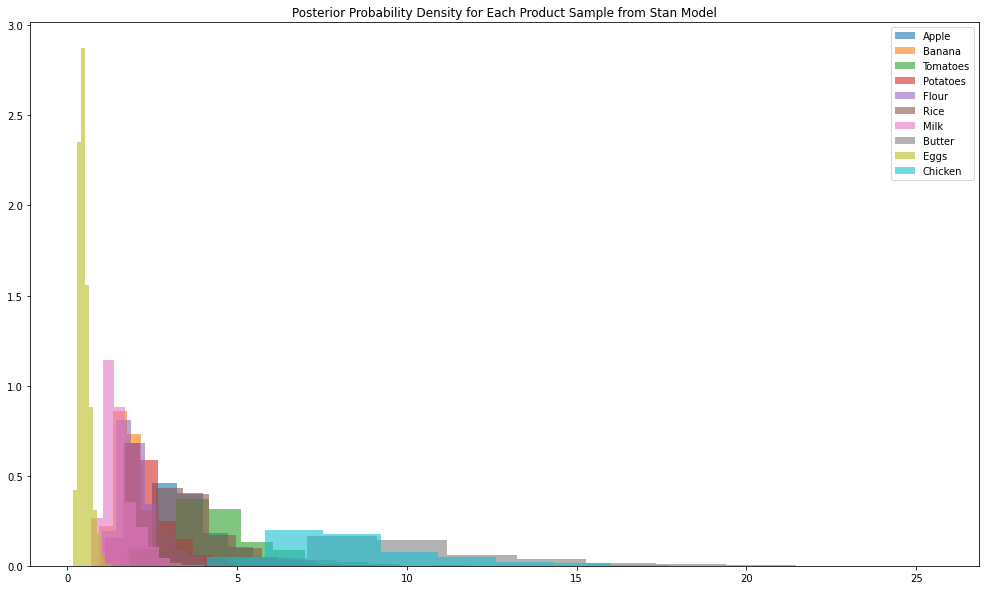

,Product,Mean,Posterior 95% CI,Standard Error
0,Apple,3.65,"[2.189347783555098, 6.5007994394488176]",1.06
1,Banana,1.95,"[1.147710293495331, 3.4769264555083685]",0.57
2,Tomatoes,4.65,"[2.791974165791479, 8.217398874411698]",1.34
3,Potatoes,2.40,"[1.4260177188205418, 4.25863625664442]",0.69
4,Flour,2.10,"[1.2463144898934724, 3.6689366719231735]",0.61
5,Rice,3.85,"[2.326127726615623, 6.830492133876708]",1.12
6,Milk,1.51,"[0.8961532727053247, 2.63128537262837]",0.44
7,Butter,10.22,"[6.15386919066229, 18.110531375823058]",2.95
8,Eggs,0.50,"[0.26843888735140947, 0.8935397336119508]",0.16
9,Chicken,8.45,"[5.075256329903639, 14.986590379375427]",2.44


In [ ]:
# dataframe of relevant metrics
products_df = pd.DataFrame(columns=['Product', 'Mean', 'Posterior 95% CI', 'Standard Error'])

# plot the posterior probability density function for each product
plt.figure(figsize=(17,10))
plt.title('Posterior Probability Density for Each Product Sample from Stan Model')

for i in range(len(product_list)):
  plt.hist(samples['base_price'][:,i], bins=10, density=True,
           alpha=0.6, label=product_list[i+1])
  # also store this data in the new df for future analysis

  products_df.loc[i] = (product_list[i+1],
                   round(np.mean(samples['base_price'][:,i]), 2),
                   np.percentile(samples['base_price'][:,i], [2.5, 97.5]),
                   round(np.std(samples['base_price'][:,i], ddof=1), 2)
                   )
  

  products_df.loc[i] = (product_list[i+1],
                   round(np.mean(samples['base_price'][:,i]), 2),
                   np.percentile(samples['base_price'][:,i], [2.5, 97.5]),
                   round(np.std(samples['base_price'][:,i], ddof=1), 2)
                   )
plt.legend()
plt.show()

products_df

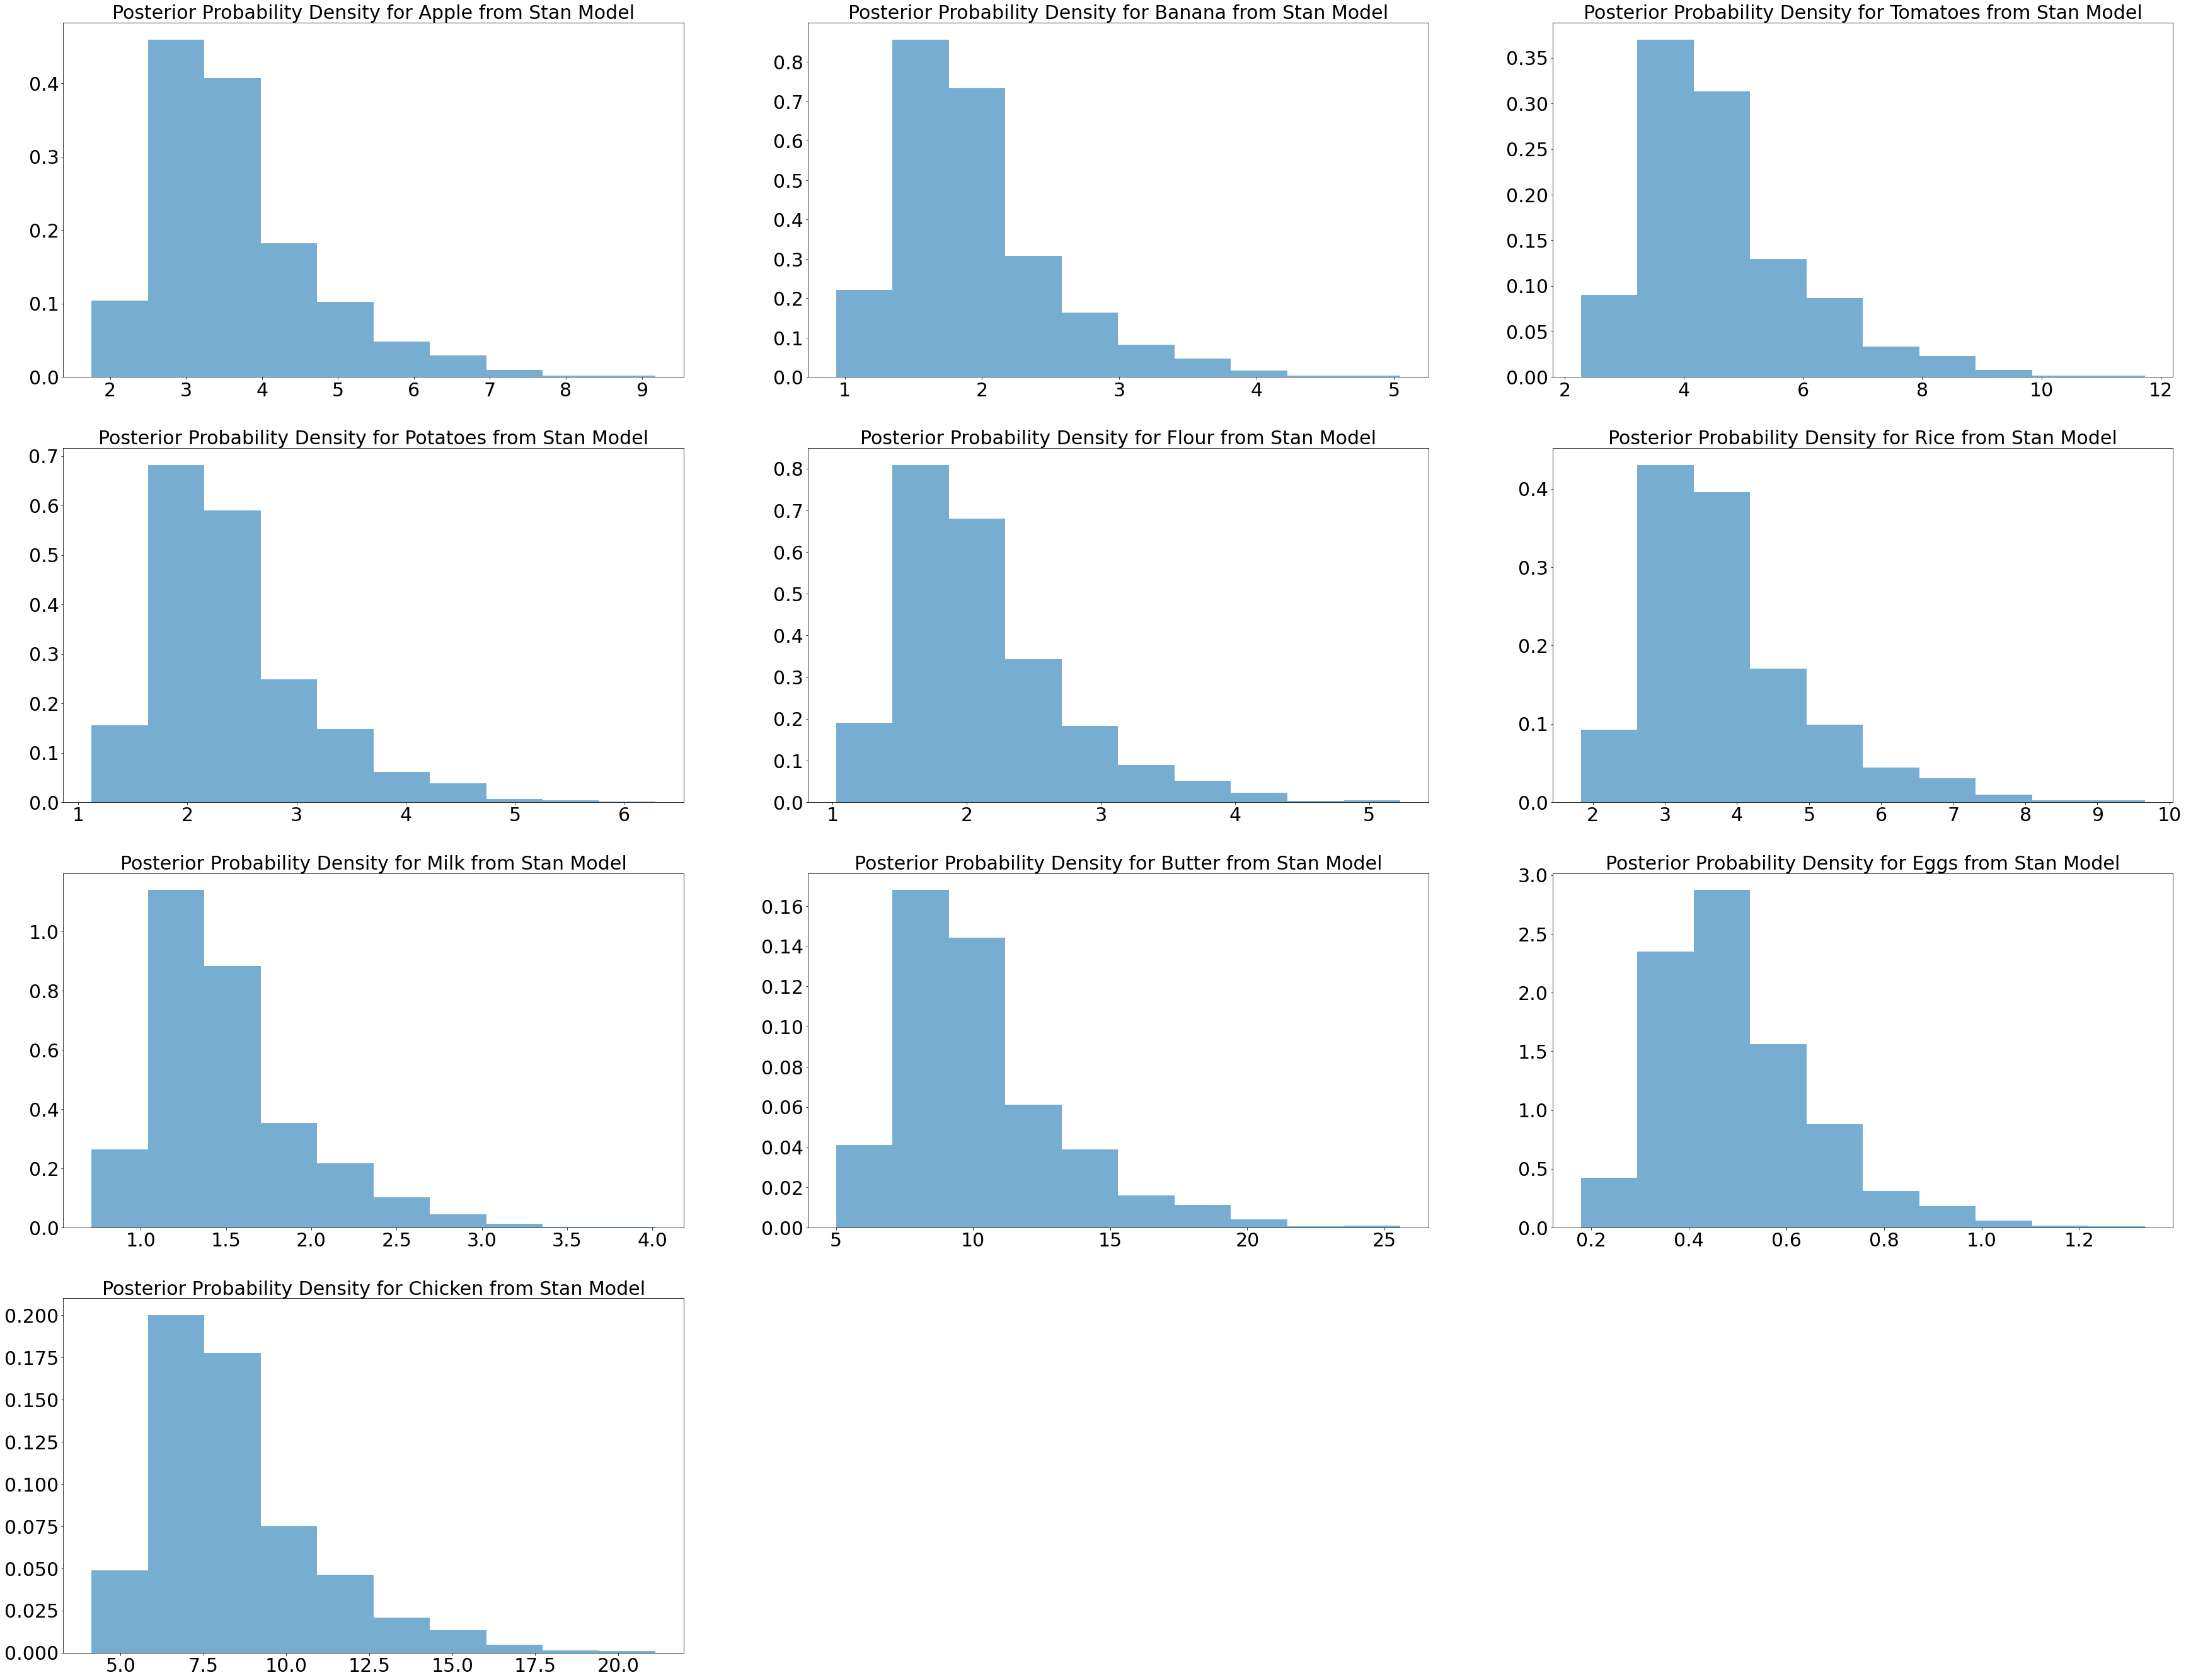

In [ ]:
# plot the posterior probability density function for each product
plt.figure(1, figsize=(60,60))

n=0
for i in range(len(product_list)):
  n+=1
  plt.subplot(5,3,n)
  plt.hist(samples['base_price'][:,i], bins=10, density=True,
           alpha=0.6)
  plt.title('Posterior Probability Density for {} from Stan Model'.format(product_list[i+1]), fontsize=30)
  plt.xticks(fontsize=30), plt.yticks(fontsize=30)
plt.show()





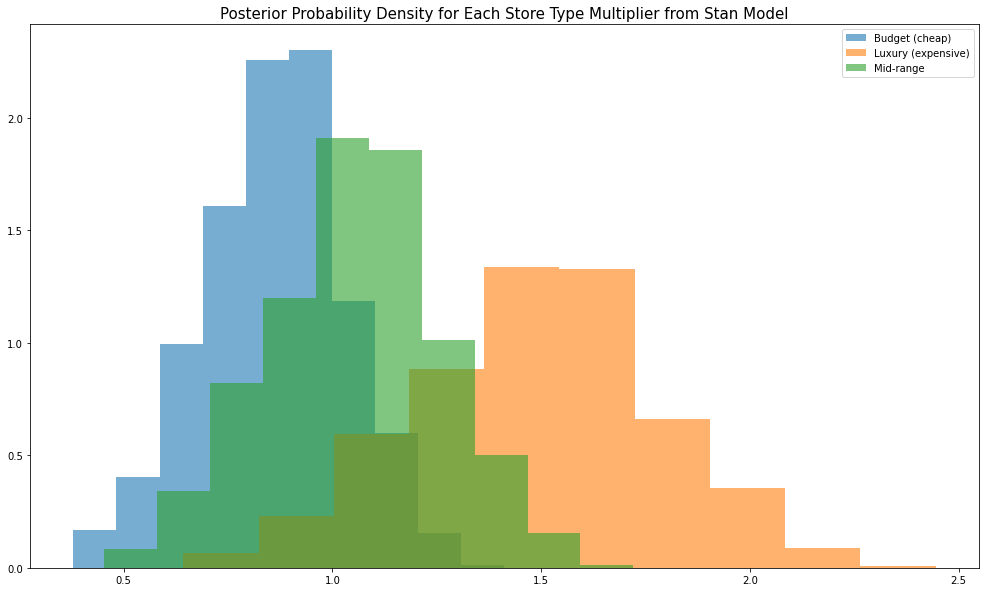

,Store Type,Mean,Posterior 95% CI,Standard Error
0,Budget (cheap),0.86,"[0.5358933833890444, 1.1928633702104905]",0.17
1,Luxury (expensive),1.49,"[0.9230224271105572, 2.0599740399085227]",0.29
2,Mid-range,1.05,"[0.6531475156860954, 1.4600449109875555]",0.21


In [ ]:
# Repeat the same thing but for Store Type
# dataframe of relevant metrics
types_df = pd.DataFrame(columns=['Store Type', 'Mean', 'Posterior 95% CI', 'Standard Error'])

# plot the posterior probability density function for each product
plt.figure(figsize=(17,10))
plt.title('Posterior Probability Density for Each Store Type Multiplier from Stan Model', fontsize=15)

for i in range(len(brand_list)):
  plt.hist(samples['store_multiplier'][:,i], bins=10, density=True,
           alpha=0.6, label=brand_list[i+1])
  # also store this data in the new df for future analysis

  types_df.loc[i] = (brand_list[i+1],
                   round(np.mean(samples['store_multiplier'][:,i]), 2),
                   np.percentile(samples['store_multiplier'][:,i], [2.5, 97.5]),
                   round(np.std(samples['store_multiplier'][:,i], ddof=1), 2)
                   )
  
plt.legend()
plt.show()

types_df

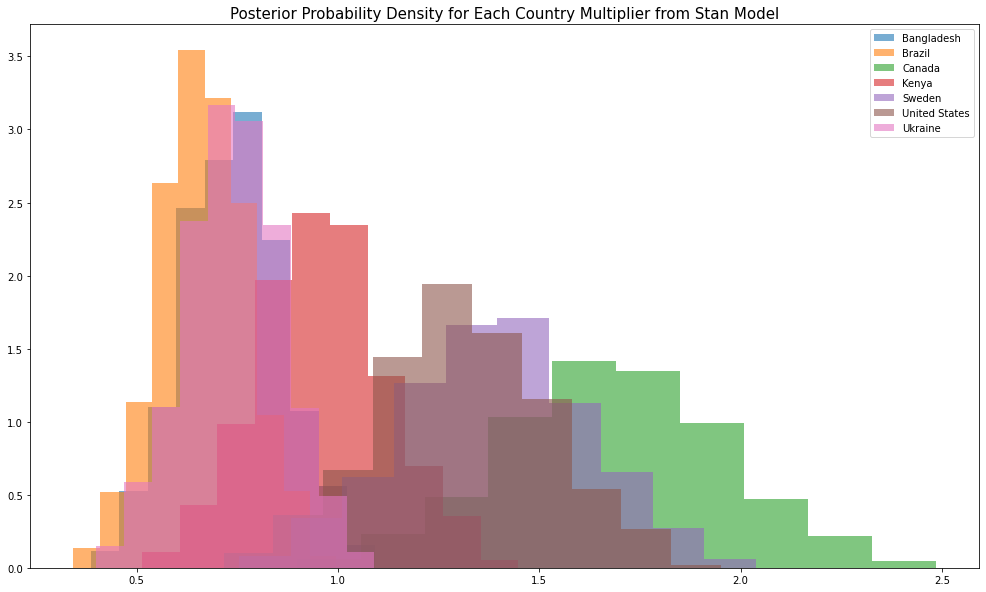

,Country,Mean,Posterior 95% CI,Standard Error
0,Bangladesh,0.74,"[0.5030725029897467, 0.9907179997867308]",0.12
1,Brazil,0.67,"[0.44886807065264783, 0.8817900250123364]",0.11
2,Canada,1.68,"[1.1524313473908776, 2.2273109808114464]",0.27
3,Kenya,0.96,"[0.6500286078950732, 1.2913893202825952]",0.16
4,Sweden,1.39,"[0.9436440107537404, 1.8487648049246057]",0.23
5,United States,1.31,"[0.8987917168757252, 1.735424995897578]",0.21
6,Ukraine,0.74,"[0.5055808871065235, 0.9836431888586188]",0.12


In [ ]:
# Repeat the same thing but for Country 
# dataframe of relevant metrics
countries_df = pd.DataFrame(columns=['Country', 'Mean', 'Posterior 95% CI', 'Standard Error'])

# plot the posterior probability density function for each product
plt.figure(figsize=(17,10))
plt.title('Posterior Probability Density for Each Country Multiplier from Stan Model', fontsize=15)

for i in range(len(country_list)):
  plt.hist(samples['country_multiplier'][:,i], bins=10, density=True,
           alpha=0.6, label=country_list[i+1])
  # also store this data in the new df for future analysis

  countries_df.loc[i] = (country_list[i+1],
                   round(np.mean(samples['country_multiplier'][:,i]), 2),
                   np.percentile(samples['country_multiplier'][:,i], [2.5, 97.5]),
                   round(np.std(samples['country_multiplier'][:,i], ddof=1), 2)
                   )
  
plt.legend()
plt.show()

countries_df

### Compare Rental Price and Country Multiplier

In [ ]:
loc_compare = countries_df[['Country', 'Mean']]

bang = data[data['Country'] == 'Bangladesh']
bang = bang['Rent']

brazil = data[data['Country'] == 'Brazil']
brazil = brazil['Rent']

can = data[data['Country'] == 'Canada']
can = can['Rent']

ken = data[data['Country'] == 'Kenya']
ken = ken['Rent']

swe = data[data['Country'] == 'Sweden']
swe = swe['Rent']

usa = data[data['Country'] == 'USA']
usa = usa['Rent']

ukr = data[data['Country'] == 'Ukraine']
ukr = ukr['Rent']

avg_rent = [np.mean(bang), np.mean(brazil), np.mean(can), np.mean(ken), np.mean(swe), np.mean(usa), np.mean(ukr)]
std_rent = [np.std(bang), np.std(brazil), np.std(can), np.std(ken), np.std(swe), np.std(usa), np.std(ukr)]


loc_compare['Avg Rental'] = np.round(avg_rent, 2)
loc_compare['Rental StDev'] = np.round(std_rent, 2)


loc_compare

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Country,Mean,Avg Rental,Rental StDev
0,Bangladesh,0.74,42.00,6.00
1,Brazil,0.67,144.00,0.00
2,Canada,1.68,1185.00,39.50
3,Kenya,0.96,455.00,0.00
4,Sweden,1.39,826.44,0.00
5,United States,1.31,2783.24,971.01
6,Ukraine,0.74,148.50,128.78


In [ ]:
mean_country = loc_compare['Mean'].to_numpy().reshape(-1, 1)
avg_rent = np.array(avg_rent).reshape(-1, 1)

reg = LinearRegression().fit(mean_country, avg_rent)
reg.score(mean_country, avg_rent)